In [104]:
import dask, dask.distributed
import dask_jobqueue
import parcels
import numpy as np
from datetime import timedelta
import xarray as xr
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from glob import glob
import tqdm as tqdm
import datetime
import cf
import pandas as pd

In [200]:
n_particles_per_release = 100
#[-7,-11],[66,65]

lon_bds = (-7, -12)
lat_bds = (65., 65.)

lon = np.random.uniform(*lon_bds, size=(n_particles_per_release,))
lat = np.random.uniform(*lat_bds, size=(n_particles_per_release,))
depth = np.random.uniform(25, 35, size=(n_particles_per_release,))

In [201]:
from parcels import (
    FieldSet, 
    ParticleSet, 
    JITParticle, 
    AdvectionRK4_3D, 
    ParticleFile,
    Variable
)
from parcels import ParticleFile

inpath='/gxfs_work/geomar/smomw452/GLORYS12/Data/'

max_ind = None

# start from 1993! 
ufiles = sorted(glob(f"{inpath}/U/*.nc"))[2:max_ind]#[2:max_ind]
#ufiles = [f for f in ufiles if '2019' in f]

vfiles = sorted(glob(f"{inpath}/V/*.nc"))[2:max_ind] #[2:max_ind] #[-366*3:] #[:5]#[:360]
#vfiles = [f for f in vfiles if '2019' in f]

wfiles = sorted(glob(f"{inpath}/W/*.nc"))[2:max_ind]#[2:max_ind] #[-366*3:] #[:5]#[:360] #-366*3:
#wfiles = [f for f in wfiles if '2019' in f]

sfiles = sorted(glob(f"{inpath}/S/*.nc"))[2:max_ind]#[2:max_ind] #[-366*3:]#[:5]
#sfiles = [f for f in sfiles if '2019' in f]

tfiles = sorted(glob(f"{inpath}/T/*.nc"))[2:max_ind]#[2:max_ind] #[-366*3:]#[:5] 
#tfiles = [f for f in tfiles if '2019' in f]


In [202]:

timestamps = np.arange(
    np.datetime64(ufiles[0][-13:-3]),
    np.datetime64(ufiles[-1][-13:-3])
    + np.timedelta64(1, "h"),  # adding an hour to include the last day
    np.timedelta64(1, "D"),
)
assert (
    len(ufiles) == len(vfiles) == len(timestamps)
), "Different number of U, V files and timestamps"
timestamps = [[t] for t in timestamps]  # convert to a list of lists


variables = {
    "U": "vozocrtx",
    "V": "vomecrty",
    "W": "vovecrtz",
    "S": "vosaline",
    "T": "votemper",
}

filenames = {
    "U": {
        "lon": wfiles[0],
        "lat": wfiles[0],
        "depth": wfiles[0],
        "data": ufiles,
    },  # must use same everywhere w,files. but w depth is 0, northeast corner of T grid is lid
    "V": {"lon": wfiles[0], "lat": wfiles[0], "depth": wfiles[0], "data": vfiles},
    "W": {"lon": wfiles[0], "lat": wfiles[0], "depth": wfiles[0], "data": wfiles},
    "S": {"lon": wfiles[0], "lat": wfiles[0], "depth": wfiles[0], "data": sfiles},
    "T": {"lon": wfiles[0], "lat": wfiles[0], "depth": wfiles[0], "data": tfiles},
}


c_grid_dimensions = {
    "lon": "nav_lon",
    "lat": "nav_lat",
    "depth": "depthw",
    "time": "time_counter",
}

dimensions = {
    "U": c_grid_dimensions,
    "V": c_grid_dimensions,
    "W": c_grid_dimensions,
    "S": c_grid_dimensions,
    "T": c_grid_dimensions,
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", parcels.FileWarning)
    fieldsetC = parcels.FieldSet.from_nemo(
        filenames,
        variables,
        dimensions,
        timestamps=timestamps,
        allow_time_extrapolation=True,
    )

In [203]:
class SampleParticle(JITParticle):
    temp = Variable('temp', dtype=np.float32, initial=-100) #fieldsetC.T
    salt = Variable('salt', dtype=np.float32, initial=-100)
    age  = Variable('age',  dtype=np.float32, initial=0)
    #uvel = Variable("uvel", dtype=np.float32, initial=0)
    #vvel = Variable("vvel", dtype=np.float32, initial=0)


def DeleteErrorParticle(particle, fieldset, time):
    if particle.state >= 40:  # deletes every particle that throws an error
        particle.delete()

def age(particle, fieldset, time):
    ''' Calculate age of particles as time after release in hours '''
    particle.age += particle.dt / 3600


def sampling(particle, fieldset, time):
    '''Sample temperature & salinity.'''
    particle.temp = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.salt = fieldset.S[time, particle.depth, particle.lat, particle.lon]

def DeleteParticle(particle, fieldset, time):
    print("Particle [%d] lost !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
    particle.delete()

# combining delete error and beached particles 
def DeleteParticle_outside_domain_beached(particle, fieldset, time):
    if particle.state >= 40:  # Check for error state
        print("Particle [%d] lost due to error !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
        particle.delete()
    elif particle.depth < 0:  # Check for beached state
        print("Particle [%d] lost due to beaching !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
        particle.delete()


In [204]:
release_times = pd.date_range(start='1993-01-01', end='1995-12-31', freq='5D')

In [172]:
release_times

DatetimeIndex(['1993-01-01', '1993-01-06', '1993-01-11', '1993-01-16',
               '1993-01-21', '1993-01-26', '1993-01-31', '1993-02-05',
               '1993-02-10', '1993-02-15',
               ...
               '1995-11-12', '1995-11-17', '1995-11-22', '1995-11-27',
               '1995-12-02', '1995-12-07', '1995-12-12', '1995-12-17',
               '1995-12-22', '1995-12-27'],
              dtype='datetime64[ns]', length=219, freq='5D')

In [205]:
release_times = pd.date_range(start='1993-01-01', end='1995-12-31', freq='5D')
lon_release = lon  # longitude of release
lat_release = lat  # latitude of release
depth_release = depth  # depth of release, meters
time_release = release_times  # time of release

In [206]:
np.repeat(time_release, len(lon_release))

DatetimeIndex(['1993-01-01', '1993-01-01', '1993-01-01', '1993-01-01',
               '1993-01-01', '1993-01-01', '1993-01-01', '1993-01-01',
               '1993-01-01', '1993-01-01',
               ...
               '1995-12-27', '1995-12-27', '1995-12-27', '1995-12-27',
               '1995-12-27', '1995-12-27', '1995-12-27', '1995-12-27',
               '1995-12-27', '1995-12-27'],
              dtype='datetime64[ns]', length=21900, freq=None)

In [175]:
print("Number of particles:", len(pset))

Number of particles: 21900


In [176]:
print("Release times:", release_times)


Release times: DatetimeIndex(['1993-01-01', '1993-01-06', '1993-01-11', '1993-01-16',
               '1993-01-21', '1993-01-26', '1993-01-31', '1993-02-05',
               '1993-02-10', '1993-02-15',
               ...
               '1995-11-12', '1995-11-17', '1995-11-22', '1995-11-27',
               '1995-12-02', '1995-12-07', '1995-12-12', '1995-12-17',
               '1995-12-22', '1995-12-27'],
              dtype='datetime64[ns]', length=219, freq='5D')


In [207]:
pset = parcels.ParticleSet.from_list(
        fieldset=fieldsetC,
        pclass=SampleParticle,
        lon=np.tile(lon_release, len(time_release)),
        lat=np.tile(lat_release, len(time_release)),
        depth=np.tile(depth_release, len(time_release)),
        time=np.repeat(time_release, len(lon_release)),
    )


adv = pset.Kernel(parcels.AdvectionRK4_3D)
age = pset.Kernel(age)
sample = pset.Kernel(sampling)
deleteparticle = pset.Kernel(DeleteParticle_outside_domain_beached)

kernels = adv+sample+age+deleteparticle 

In [208]:
outputfile = ParticleFile('release_test3.zarr',pset,timedelta(hours=24), chunks=(len(pset),1)) # timedelta was 6 before 


In [ ]:
pset.execute(kernels, runtime=timedelta(days=500), dt=timedelta(minutes=10), output_file=outputfile) 


INFO: Output files are stored in release_test3.zarr.
Output files are stored in release_test3.zarr.
 51%|█████     | 22118400.0/43200000.0 [09:35<13:17, 26425.60it/s]Correct cell not found for (23.473505, 71.185352) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 400 499
            new particle indices: (yi, xi) 400 0
            Mesh 2d shape:  601 501
            Relative particle position:  (xsi, eta) 1.0040428548534313e+00 2.3099084283794705e-01
Correct cell not found for (23.474814, 71.185608) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 400 499
            new particle indices: (yi, xi) 400 0
            Mesh 2d shape:  601 501
            Relative particle position:  (xsi, eta) 1.0086182949820501e+00 2.4160479943406701e-01
Particle [132009] lost due to error !! (23.4722 71.1851 31.4026 2.21268e+07)
 53%|█████▎    | 22982400.0/43200000.0 [10:05<12:53, 26137.51it/s]Correct cell not found for (28.006888, 72.888101) after 1000000 iteration

In [180]:
for particle in pset:
    print(particle.time)

25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0
25919400.0

In [181]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [193]:
#ds = xr.open_dataset('expt_test_hjalmar2.zarr', engine='zarr', chunks='auto') 
ds = xr.open_dataset('release_test2.zarr', engine='zarr', chunks='auto') 

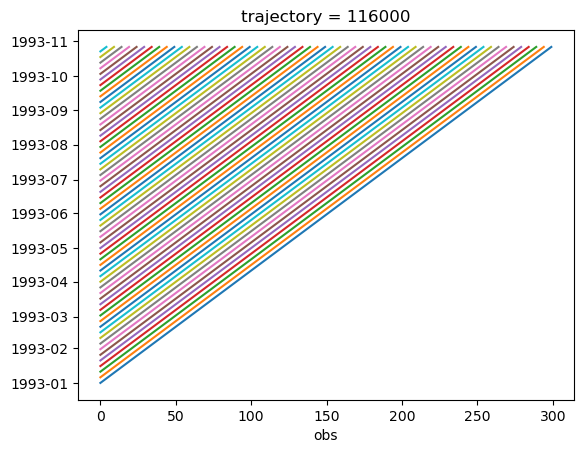

In [198]:
for i in np.arange(0,ds.trajectory.size,100):
    ds.isel(trajectory=i).time.plot()
plt.show()

In [184]:
ds.trajectory.size

6000

In [189]:

ds.isel(trajectory=1).time.

301

In [199]:
ds.isel(trajectory=-800).time.values

array(['1993-09-18T00:00:00.000000000', '1993-09-19T00:00:00.000000000',
       '1993-09-20T00:00:00.000000000', '1993-09-21T00:00:00.000000000',
       '1993-09-22T00:00:00.000000000', '1993-09-23T00:00:00.000000000',
       '1993-09-24T00:00:00.000000000', '1993-09-25T00:00:00.000000000',
       '1993-09-26T00:00:00.000000000', '1993-09-27T00:00:00.000000000',
       '1993-09-28T00:00:00.000000000', '1993-09-29T00:00:00.000000000',
       '1993-09-30T00:00:00.000000000', '1993-10-01T00:00:00.000000000',
       '1993-10-02T00:00:00.000000000', '1993-10-03T00:00:00.000000000',
       '1993-10-04T00:00:00.000000000', '1993-10-05T00:00:00.000000000',
       '1993-10-06T00:00:00.000000000', '1993-10-07T00:00:00.000000000',
       '1993-10-08T00:00:00.000000000', '1993-10-09T00:00:00.000000000',
       '1993-10-10T00:00:00.000000000', '1993-10-11T00:00:00.000000000',
       '1993-10-12T00:00:00.000000000', '1993-10-13T00:00:00.000000000',
       '1993-10-14T00:00:00.000000000', '1993-10-15

In [123]:
ds.isel(trajectory=-8).time.values

array(['1993-10-23T00:00:00.000000000', '1993-10-24T00:00:00.000000000',
       '1993-10-25T00:00:00.000000000', '1993-10-26T00:00:00.000000000',
       '1993-10-27T00:00:00.000000000',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',            

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351352353354355356357358359360361362363364365366367368369

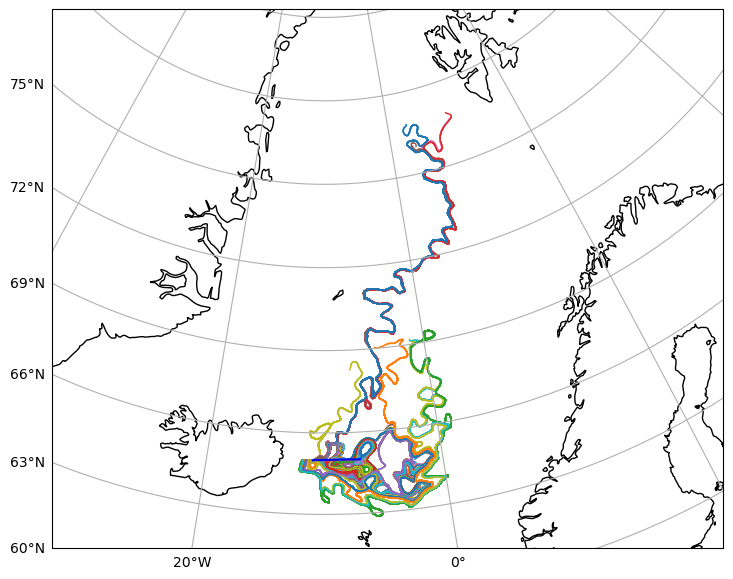

In [124]:
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import tqdm

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))

ax.set_extent([-30, 20, 60, 80], crs=ccrs.PlateCarree())
# Loop through the trajectories and plot them
i = np.arange(0, ds.trajectory.size, 1) #np.arange(ds_filter.trajectory.size) #
colors = list(mcolors.TABLEAU_COLORS.values())
for idx, index in enumerate(i):
    print(idx,end='')
    # Use plt.plot to connect the points with a line
    ax.plot(
        ds.lon.isel(trajectory=index), 
        ds.lat.isel(trajectory=index), 
        color=colors[idx % len(colors)], 
        linewidth=1,  # Adjust the line width here
        transform=ccrs.PlateCarree()
    )
#plt.plot([-7,-11],[65,66],color='red', transform=ccrs.PlateCarree())
plt.plot([-7,-11],[65,65],color='blue', transform=ccrs.PlateCarree())
# Add coastlines
ax.coastlines()
# Add gridlines for longitude and latitude
gl = ax.gridlines(draw_labels=True,dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

#plt.savefig('particle_release',dpi=600,bbox_inches='tight',transparent=False)
plt.show()


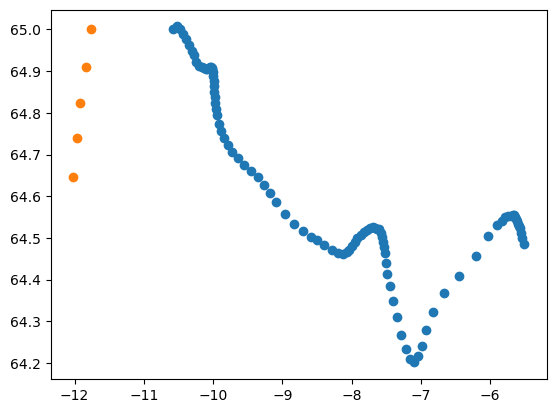

In [89]:
plt.scatter(ds.lon.isel(trajectory=0),ds.lat.isel(trajectory=0))
plt.scatter(ds.lon.isel(trajectory=-1),ds.lat.isel(trajectory=-1))